# SPAM detection case study - XGBoost and NLP

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from nltk.stem.snowball import EnglishStemmer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight

from matplotlib import pyplot as plt
import xgboost as xgb
import pandas as pd
import numpy as np
pd.set_option("display.max_colwidth", 500)

ModuleNotFoundError: No module named 'xgboost'

## Load the data

In [ ]:
df = pd.read_csv('spam_sms.csv', encoding="WINDOWS-1252")

In [ ]:
df['is_spam'] = df['v1'] == 'spam'
df.rename(columns={'v2': 'text'}, inplace=True)
df.drop(columns=['v1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)
df.drop_duplicates(inplace=True)

In [ ]:
df

,text,is_spam
0,"Go until jurong point, crazy.. Available only ...",False
1,Ok lar... Joking wif u oni...,False
2,Free entry in 2 a wkly comp to win FA Cup fina...,True
3,U dun say so early hor... U c already then say...,False
4,"Nah I don't think he goes to usf, he lives aro...",False
...,...,...
5567,This is the 2nd time we have tried 2 contact u...,True
5568,Will Ì_ b going to esplanade fr home?,False
5569,"Pity, * was in mood for that. So...any other s...",False
5570,The guy did some bitching but I acted like i'd...,False


In [ ]:
df

,text,is_spam
0,"Go until jurong point, crazy.. Available only ...",False
1,Ok lar... Joking wif u oni...,False
2,Free entry in 2 a wkly comp to win FA Cup fina...,True
3,U dun say so early hor... U c already then say...,False
4,"Nah I don't think he goes to usf, he lives aro...",False
...,...,...
5567,This is the 2nd time we have tried 2 contact u...,True
5568,Will Ì_ b going to esplanade fr home?,False
5569,"Pity, * was in mood for that. So...any other s...",False
5570,The guy did some bitching but I acted like i'd...,False


## Introduction to vectorizing and stemming

In [6]:
import pandas as pd
pd.Series(texts)

0          Hello how are you doing? --- $
1    doing are )) - you Hello how ? --- $
2      Good morning, how do you do? --- $
3                We are in a ML bootcamp!
dtype: object

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

texts = [
    'Hello how are you doing? --- $',
    'doing are )) - you Hello how ? --- $',
    'Good morning, how do you do? --- $',
    'We are in a ML bootcamp!'
]

In [ ]:
texts

['Hello how are you doing? --- $',
 'doing are )) - you Hello how ? --- $',
 'Good morning, how do you do? --- $',
 'We are in a ML bootcamp!']

In [ ]:
vectorizer = CountVectorizer(stop_words="english", ngram_range=(1, 2))

In [ ]:
vectors = vectorizer.fit_transform(texts).todense()

In [ ]:
vocabulary = vectorizer.get_feature_names_out()

In [ ]:
pd.DataFrame(vectors, columns=vocabulary, index=texts)

,bootcamp,doing,doing hello,good,good morning,hello,hello doing,ml,ml bootcamp,morning
Hello how are you doing? --- $,0,1,0,0,0,1,1,0,0,0
doing are )) - you Hello how ? --- $,0,1,1,0,0,1,0,0,0,0
"Good morning, how do you do? --- $",0,0,0,1,1,0,0,0,0,1
We are in a ML bootcamp!,1,0,0,0,0,0,0,1,1,0


### Introduction to stemming

In [ ]:
from nltk.stem.snowball import EnglishStemmer
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS

In [ ]:
# Can handle for instance texts like "Apache/2.3.4"
def simple_text_analyzer(text):
    return text.split('/')

In [ ]:
stemmer = EnglishStemmer()
stemmer.stem('doing')

'do'

In [ ]:
ENGLISH_STOP_WORDS_CUSTOM = ENGLISH_STOP_WORDS - {'do', 'first'}

In [ ]:
'do' in ENGLISH_STOP_WORDS_CUSTOM

False

In [ ]:
default_analyzer = CountVectorizer(stop_words=ENGLISH_STOP_WORDS_CUSTOM).build_analyzer()

In [ ]:
default_analyzer("Hello how are you doing today?")

['hello', 'doing', 'today']

In [ ]:
def analyze_with_stemming(text):
    unstemmed_words = default_analyzer(text)
    return (stemmer.stem(word) for word in unstemmed_words)

In [ ]:
DO_NOT_STEM_SET = {'morning'}
def analyze_with_stemming2(text):
    unstemmed_words = default_analyzer(text)
    return (word if word in DO_NOT_STEM_SET else stemmer.stem(word)
            for word in unstemmed_words)

In [ ]:
list(analyze_with_stemming("Hello how are you doing today?"))

['hello', 'do', 'today']

In [ ]:
stemmer_vectorizer = CountVectorizer(analyzer=analyze_with_stemming)

In [ ]:
vectors = stemmer_vectorizer.fit_transform(texts).todense()
vocabulary = stemmer_vectorizer.get_feature_names_out()
pd.DataFrame(vectors, columns=vocabulary, index=texts)

,bootcamp,do,good,hello,ml,morn
Hello how are you doing? --- $,0,1,0,1,0,0
doing are )) - you Hello how ? --- $,0,1,0,1,0,0
"Good morning, how do you do? --- $",0,2,1,0,0,1
We are in a ML bootcamp!,1,0,0,0,1,0


### Prepare the train and test datasets

In [ ]:
texts = df['text']
Y = df['is_spam']

In [ ]:
texts_train, texts_test, Y_train, Y_test = train_test_split(texts, Y, test_size=0.15,
                                                            random_state=432)

In [ ]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(texts_train)
X_test = vectorizer.transform(texts_test)

## Training the model

In [ ]:
model = xgb.XGBClassifier()

In [ ]:
# # Just to test that there is no coding or preprocessing error
# model.fit(X_train, Y_train)

In [ ]:
search_cv = GridSearchCV(model,
                         param_grid={
                             'max_depth': [1, 5, 10, 30, 50, 70, 100, 200, 300]
                         },
                         cv=3,
                         scoring='roc_auc')

In [ ]:
search_cv.fit(X_train, Y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'max_depth': [1, 5, 10, 30, 50, 70, 100, 200, 300]},
             scoring='roc_auc')

In [ ]:
search_cv.best_params_

{'max_depth': 5}

In [ ]:
search_cv.best_score_

0.9797773031600424

### Handle class inbalance
By default, XGBoost handles class inbalance pretty well (around 0.97 area under ROC curve on the test set).
But in case we want to handle it specifically, we can use `sample_weight`:

In [ ]:
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=Y_train
)

In [ ]:
search_cv.fit(X_train, Y_train)
search_cv.best_params_, search_cv.best_score_

({'max_depth': 5}, 0.9797773031600424)

In [ ]:
cv_results = pd.DataFrame(search_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.083549,0.011442,0.002743,0.000386,1,{'max_depth': 1},0.988125,0.961167,0.985619,0.978304,0.012161,3
1,0.107036,0.005618,0.002898,0.000042,5,{'max_depth': 5},0.985433,0.963070,0.990829,0.979777,0.012017,1
2,0.211147,0.013367,0.003168,0.000050,10,{'max_depth': 10},0.985592,0.960159,0.990560,0.978770,0.013316,2
3,0.297217,0.019479,0.004435,0.000726,30,{'max_depth': 30},0.984913,0.954551,0.989878,0.976448,0.015615,9
4,0.273532,0.016518,0.004443,0.000089,50,{'max_depth': 50},0.987011,0.954551,0.989878,0.977147,0.016020,4
5,0.279300,0.012560,0.004750,0.000392,70,{'max_depth': 70},0.987011,0.954551,0.989878,0.977147,0.016020,4
6,0.270295,0.013965,0.004034,0.000190,100,{'max_depth': 100},0.987011,0.954551,0.989878,0.977147,0.016020,4
7,0.273823,0.017874,0.004207,0.000116,200,{'max_depth': 200},0.987011,0.954551,0.989878,0.977147,0.016020,4
8,0.269373,0.014921,0.004612,0.000759,300,{'max_depth': 300},0.987011,0.954551,0.989878,0.977147,0.016020,4


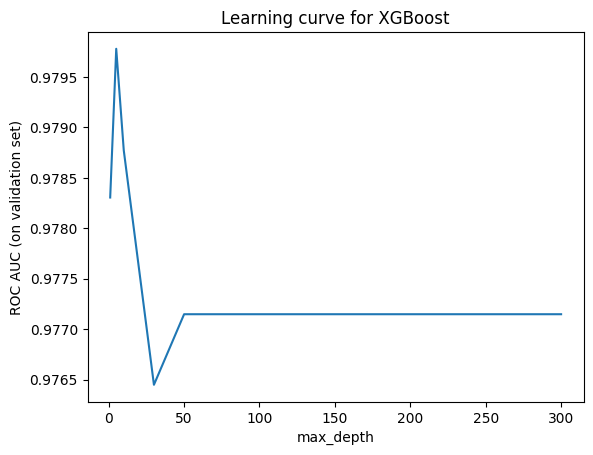

In [ ]:
plt.title("Learning curve for XGBoost")
plt.plot(cv_results['param_max_depth'], cv_results['mean_test_score'])
plt.xlabel("max_depth")
plt.ylabel("ROC AUC (on validation set)");

In [ ]:
# Automatically handled by GridSearchCV
best_model = search_cv.best_estimator_

# # Equivalent to
# model = xgb.XGBClassifier(max_depth=100)
# model.fit(X_train, Y_train)

In [ ]:
cv_results = pd.DataFrame(search_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.083549,0.011442,0.002743,0.000386,1,{'max_depth': 1},0.988125,0.961167,0.985619,0.978304,0.012161,3
1,0.107036,0.005618,0.002898,0.000042,5,{'max_depth': 5},0.985433,0.963070,0.990829,0.979777,0.012017,1
2,0.211147,0.013367,0.003168,0.000050,10,{'max_depth': 10},0.985592,0.960159,0.990560,0.978770,0.013316,2
3,0.297217,0.019479,0.004435,0.000726,30,{'max_depth': 30},0.984913,0.954551,0.989878,0.976448,0.015615,9
4,0.273532,0.016518,0.004443,0.000089,50,{'max_depth': 50},0.987011,0.954551,0.989878,0.977147,0.016020,4
5,0.279300,0.012560,0.004750,0.000392,70,{'max_depth': 70},0.987011,0.954551,0.989878,0.977147,0.016020,4
6,0.270295,0.013965,0.004034,0.000190,100,{'max_depth': 100},0.987011,0.954551,0.989878,0.977147,0.016020,4
7,0.273823,0.017874,0.004207,0.000116,200,{'max_depth': 200},0.987011,0.954551,0.989878,0.977147,0.016020,4
8,0.269373,0.014921,0.004612,0.000759,300,{'max_depth': 300},0.987011,0.954551,0.989878,0.977147,0.016020,4


### Let's try Random Forest

In [ ]:
# Random Forest handles class inbalance automatically with:
#  - class_weight='balanced_subsample' for oversampling
#  - class_weight='balanced' for sample weight

model_rf = RandomForestClassifier(class_weight='balanced_subsample')

In [ ]:
search_cv_rf = GridSearchCV(model_rf,
                            param_grid={
                                'max_depth': [1, 5, 10, 30, 50, 70, 100, 200, 300]
                            },
                            cv=3,
                            scoring='roc_auc')
search_cv_rf.fit(X_train, Y_train)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced_subsample'),
             param_grid={'max_depth': [1, 5, 10, 30, 50, 70, 100, 200, 300]},
             scoring='roc_auc')

In [ ]:
search_cv_rf.best_params_, search_cv_rf.best_score_

({'max_depth': 50}, 0.9927132233760219)

In [ ]:
cv_results_rf = pd.DataFrame(search_cv_rf.cv_results_)

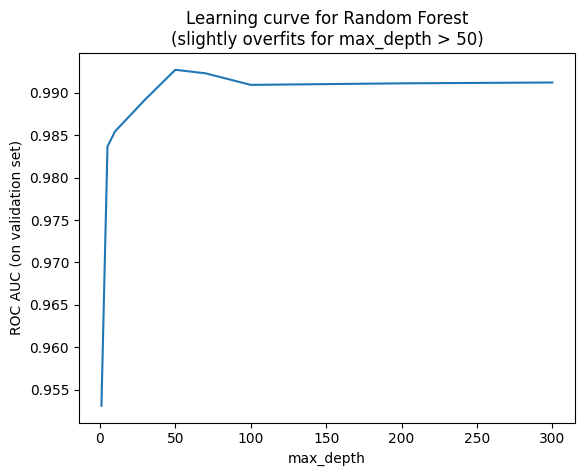

In [ ]:
plt.title("Learning curve for Random Forest\n(slightly overfits for max_depth > 50)")
plt.plot(cv_results_rf['param_max_depth'], cv_results_rf['mean_test_score'])
plt.xlabel("max_depth")
plt.ylabel("ROC AUC (on validation set)");

Let's use Random Forest, since it seems to work better. In practice, we may still choose XGBoost because it is faster, it handles categorical data natively, or maybe we didn't try hard enough with the grid search.

### Model evaluation

In [ ]:
final_model = search_cv_rf.best_estimator_

In [ ]:
# Mean ROC AUC score on the validation data sets (with cross-validation)
search_cv_rf.best_score_

0.9927132233760219

In [ ]:
# This is useless in practice, but useful to understand what is happening (the performes better on the test set)

Y_train_pred_probas = final_model.predict_proba(X_train)[:,1]
# ROC AUC on the train dataset
roc_auc_score(Y_train, Y_train_pred_probas)

0.9999761674447296

In [ ]:
Y_test_probas = final_model.predict_proba(X_test)[:,1]

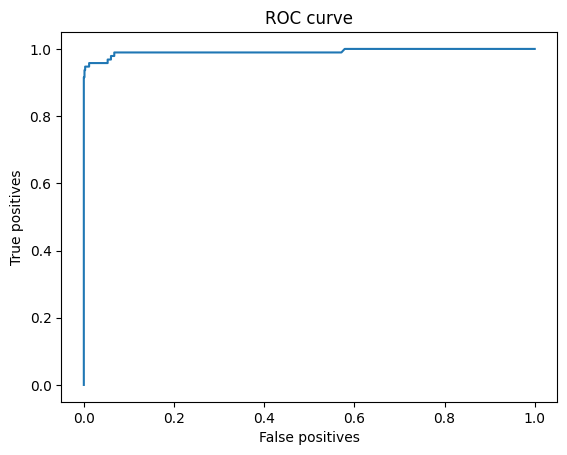

In [ ]:
# Let's plot a ROC curve, that can help us choose the threshold
fp, tp, _ = roc_curve(Y_test, Y_test_probas)
plt.title("ROC curve")
plt.xlabel("False positives")
plt.ylabel("True positives")
plt.plot(fp, tp);

In [ ]:
df_test_pred = texts_test.to_frame()
df_test_pred['pred_score'] = Y_test_probas
df_test_pred['true_class'] = Y_test

In [ ]:
# The "worst" false positives
df_test_pred[df_test_pred['true_class'] == 0].sort_values('pred_score', ascending=False).head(10)

,text,pred_score,true_class
500,"Fighting with the world is easy, u either win or lose bt fightng with some1 who is close to u is dificult if u lose - u lose if u win - u still lose.",0.287445,False
4700,I liked the new mobile,0.255837,False
420,Yes:)from last week itself i'm taking live call.,0.252034,False
4633,These won't do. Have to move on to morphine,0.245487,False
494,Are you free now?can i call now?,0.244388,False
2496,HCL chennai requires FRESHERS for voice process.Excellent english needed.Salary upto &lt;#&gt; .Call Ms.Suman &lt;#&gt; for Telephonic interview -via Indyarocks.com,0.238748,False
4033,Wot u up 2? Thout u were gonna call me!! Txt bak luv K,0.236498,False
386,Customer place i will call you.,0.230519,False
2286,I have had two more letters from . I will copy them for you cos one has a message for you. Speak soon,0.223211,False
4539,"Urgh, coach hot, smells of chip fat! Thanks again, especially for the duvet (not a predictive text word).",0.221605,False


In [ ]:
# The "worst" false negatives
df_test_pred[df_test_pred['true_class'] == 1].sort_values('pred_score', ascending=True).head(10)

,text,pred_score,true_class
3979,ringtoneking 84484,0.037171,True
3300,RCT' THNQ Adrian for U text. Rgds Vatian,0.125093,True
4819,Check Out Choose Your Babe Videos @ sms.shsex.netUN fgkslpoPW fgkslpo,0.134394,True
4067,TBS/PERSOLVO. been chasing us since Sept forå£38 definitely not paying now thanks to your information. We will ignore them. Kath. Manchester.,0.138105,True
2247,Back 2 work 2morro half term over! Can U C me 2nite 4 some sexy passion B4 I have 2 go back? Chat NOW 09099726481 Luv DENA Calls å£1/minMobsmoreLKPOBOX177HP51FL,0.226309,True
4014,You will be receiving this week's Triple Echo ringtone shortly. Enjoy it!,0.252583,True
4966,You can donate å£2.50 to UNICEF's Asian Tsunami disaster support fund by texting DONATE to 864233. å£2.50 will be added to your next bill,0.255877,True
1874,Would you like to see my XXX pics they are so hot they were nearly banned in the uk!,0.270763,True
2819,INTERFLORA - åÒIt's not too late to order Interflora flowers for christmas call 0800 505060 to place your order before Midnight tomorrow.,0.310881,True
730,Email AlertFrom: Jeri StewartSize: 2KBSubject: Low-cost prescripiton drvgsTo listen to email call 123,0.311562,True


A lot of things may be improved:
* Keep some punctuation during vectorization,
* Maybe try to keep the case (lowercase/uppercase) information,
* Normalize the data (divide by the sum for instance), so that the model is agnostic to the document length (maybe not a good idea),
* Add bigrams,
* And many more...